In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

In [2]:
plt.style.use('ggplot')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [58]:
df_train=pd.read_csv(r"C:\Users\rafae\kaggle\bike-sharing-demand\train.csv")
df_test=pd.read_csv(r"C:\Users\rafae\kaggle\bike-sharing-demand\test.csv")

In [4]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Data preparation

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [6]:
df_train["datetime"] = pd.to_datetime(df_train["datetime"], format ='%Y-%m-%d %H:%M:%S')
df_train.set_index(df_train["datetime"], inplace = True)
df_train.drop("datetime", axis = 1, inplace = True)

In [7]:
df_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
df_train.isnull().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

## Exploratory data analysis on bike demand (time series)

In [9]:
bike_series = df_train["count"]

In [10]:
type(bike_series)

pandas.core.series.Series

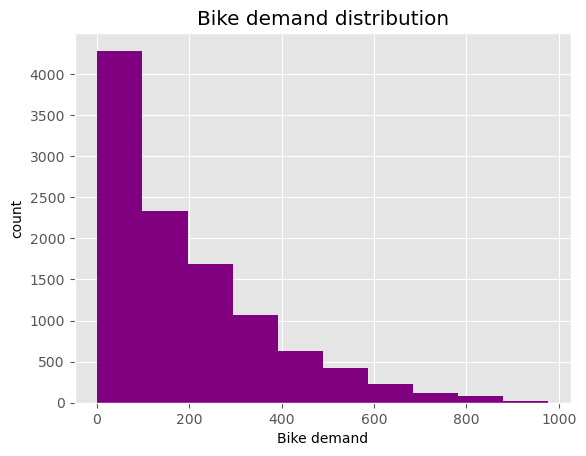

In [11]:
plt.hist(bike_series, color = "purple")

plt.title("Bike demand distribution")
plt.ylabel("count")
plt.xlabel("Bike demand")

plt.show()

The data of the bike demand does not follow a normal distribution. Lets analyze it overtime

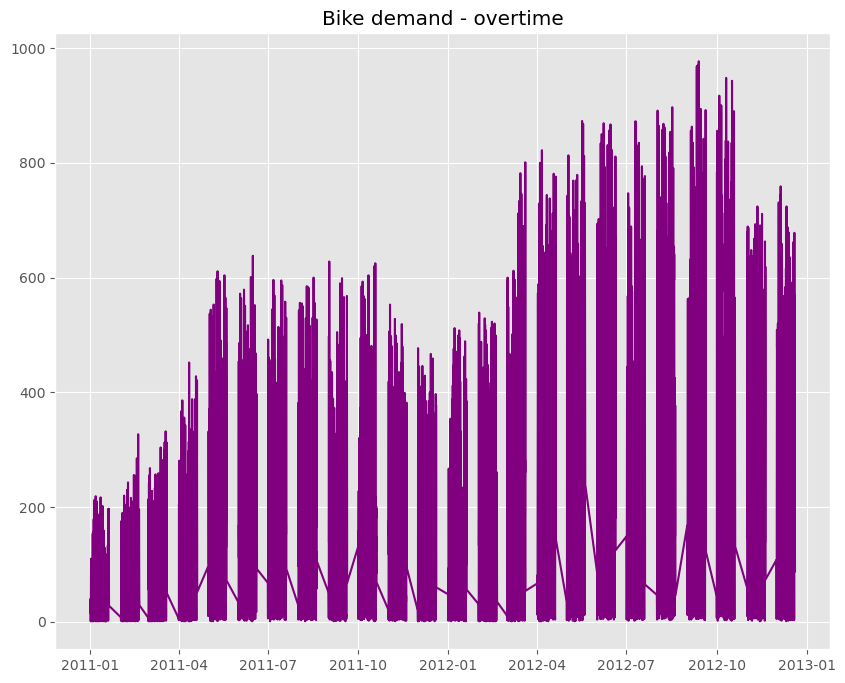

In [12]:
ax = plt.figure(figsize = (10,8))

plt.plot(bike_series, color = "purple")

plt.title("Bike demand - overtime")
plt.show()

Conclusions:

- The time series seems to have a tendency of growth
- There is moments that the demand is zero, probably during the night, the demand must be highly correlated with hours

In [13]:
index_hours = bike_series.index.hour

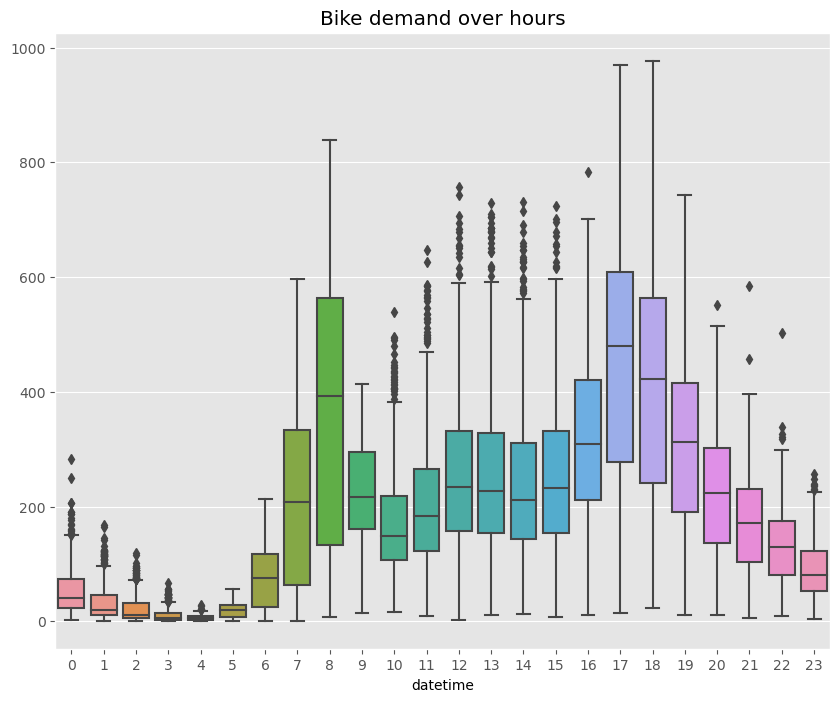

In [14]:
ax = plt.figure(figsize = (10,8))

plt.title("Bike demand over hours")

sns.boxplot(x = index_hours , y=bike_series.values)

plt.show()

Conclusions:

- We have a peak of bike demand at 6,7,8 hours and after that 16,17,18,19
- The series is higly hour correlated

Analyzing the sazonality

In [15]:
index_month = bike_series.index.month
index_year = bike_series.index.year

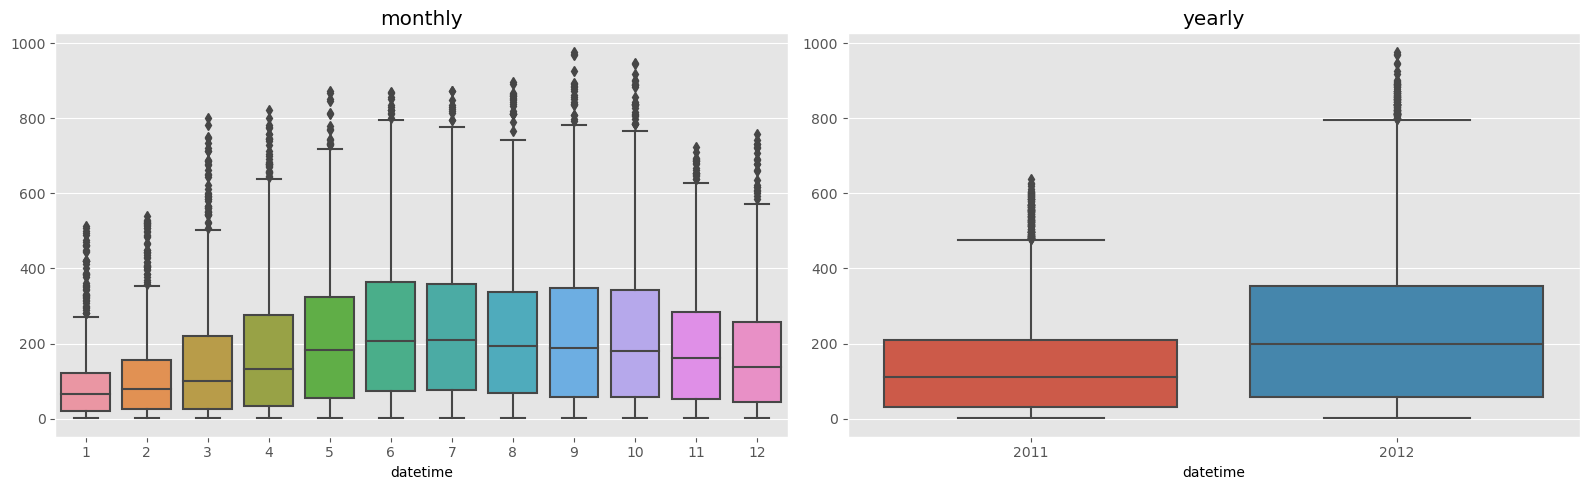

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (16,5))

sns.boxplot(x=index_month, y=bike_series.values, ax=ax[0])
ax[0].set_title("monthly")

sns.boxplot(x=index_year, y=bike_series.values, ax=ax[1])
ax[1].set_title("yearly")


plt.tight_layout()
plt.show()

Conclusion:

- The month and the year are also relevant

In [17]:
df_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Exploratory data analysis

Categorical data

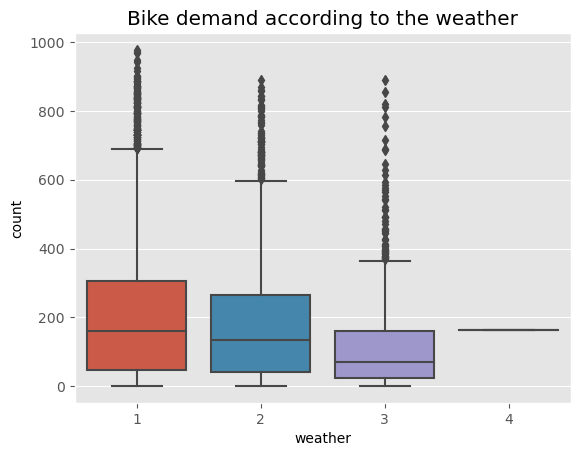

In [18]:
sns.boxplot(x = "weather", y = "count", data = df_train)

plt.title("Bike demand according to the weather")

plt.show()

In [19]:
df_train["weather"].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

The weather data is highly disbalanced

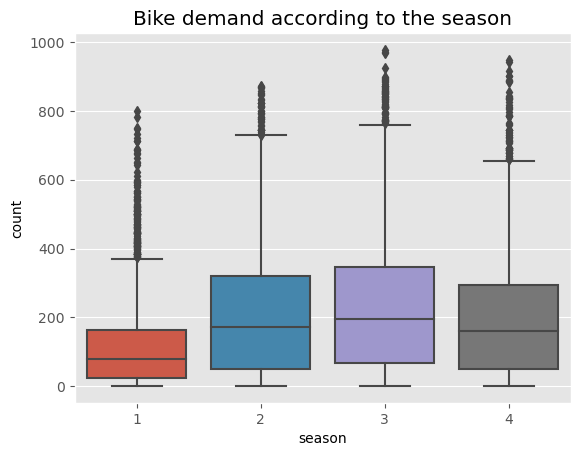

In [20]:
sns.boxplot(x = "season", y = "count", data = df_train)

plt.title("Bike demand according to the season")

plt.show()

Numeric data

In [21]:
list_numeric = []

for i in range(0,len(df_train.dtypes)):
    if df_train.dtypes[i] == "float64":
        list_numeric.append(df_train.dtypes.index[i])
    else:
        pass

In [22]:
list_numeric

['temp', 'atemp', 'windspeed']

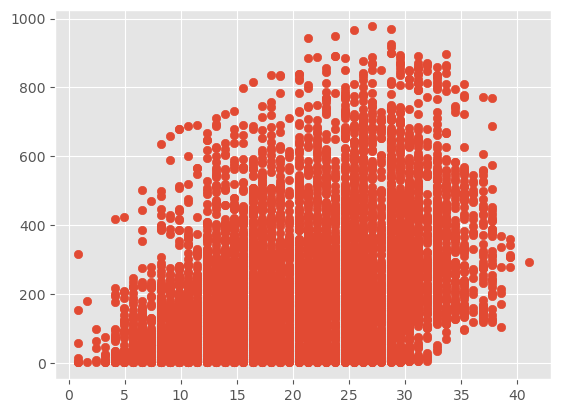

In [23]:
plt.scatter(df_train["temp"], df_train["count"])

## Organizing features

In [24]:
df_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [25]:
drop_list = ["casual","registered"]
df_train = df_train.drop(drop_list, axis = 1)

In [26]:
df_train["hour"] = df_train.index.hour
df_train["month"] = df_train.index.month
df_train["year"] = df_train.index.year

In [27]:
df_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,month,year
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,1,2011
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1,2011
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2,1,2011
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3,1,2011
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4,1,2011


In [28]:
X = df_train.drop("count", axis = 1)
y = df_train["count"]

## Data splitting

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

Fitting a baseline model

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error

In [32]:
linear_model = LinearRegression()

In [33]:
linear_model.fit(X_train,y_train)

LinearRegression()

In [34]:
y_pred_linear = linear_model.predict(X_test)

In [35]:
y_pred_linear[y_pred_linear< 0] = 0

In [37]:
np.sqrt(mean_squared_log_error(y_test, y_pred_linear))

1.3340856360056135

Fitting a more robust model

In [38]:
from sklearn.ensemble import RandomForestRegressor

In [39]:
rf_reg = RandomForestRegressor()

In [40]:
rf_reg.fit(X_train,y_train)

RandomForestRegressor()

In [41]:
y_pred_rf_reg = rf_reg.predict(X_test)

In [42]:
np.sqrt(mean_squared_log_error(y_test, y_pred_rf_reg))

0.3575675736330922

In [43]:
from sklearn.model_selection import RandomizedSearchCV

In [44]:
rf = RandomForestRegressor()

param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=10, stop=200, num=20)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(1, 20, num=20)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100, 
    cv=3,  
    verbose=2, 
    random_state=42,
    n_jobs=-1  
)


random_search.fit(X_train, y_train)

best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_train)
mse = np.sqrt(mean_squared_log_error(y_train, y_pred))

print("Melhores hiperparâmetros encontrados:", random_search.best_params_)
print("RMSLE no conjunto de traine:", mse)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\rafae\anaconda3_1\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Melhores hiperparâmetros encontrados: {'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
RMSLE no conjunto de traine: 0.1594666652924942


In [90]:
rf_reg_opt = RandomForestRegressor(
    n_estimators=60,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='auto',
    max_depth=None,
    bootstrap=True
)

In [92]:
rf_reg_opt.fit(X,y)

C:\Users\rafae\anaconda3_1\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(max_features='auto', n_estimators=60)

In [45]:
import xgboost as xgb

In [46]:
xgb_reg = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, random_state = 0,n_estimators=200)

xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [47]:
y_pred_xgb = xgb_reg.predict(X_test)

In [48]:
y_pred_xgb[y_pred_xgb < 0] = 0

In [49]:
np.sqrt(mean_squared_log_error(y_test, y_pred_xgb))

0.5018215905109987

## Cross validation

In [50]:
dmatrix = xgb.DMatrix(data = X, label = y)

In [51]:
params = {"objective": "reg:squaredlogerror", "learning_rate": 0.05, 'max_depth': 5}

cv_results = xgb.cv(dtrain = dmatrix , params = params, nfold = 3, num_boost_round = 1000, early_stopping_rounds = 5, metrics = "rmsle", as_pandas = True)

In [52]:
cv_results

,train-rmsle-mean,train-rmsle-std,test-rmsle-mean,test-rmsle-std
0,4.199585,0.011686,4.199540,0.024031
1,4.162551,0.011634,4.162512,0.023936
2,4.125614,0.011581,4.125581,0.023841
3,4.088774,0.011528,4.088747,0.023745
4,4.052033,0.011473,4.052012,0.023648
...,...,...,...,...
271,0.819632,0.004247,0.826577,0.010833
272,0.819377,0.004360,0.826270,0.010832
273,0.819156,0.004353,0.826147,0.010962
274,0.818950,0.004343,0.825677,0.010599


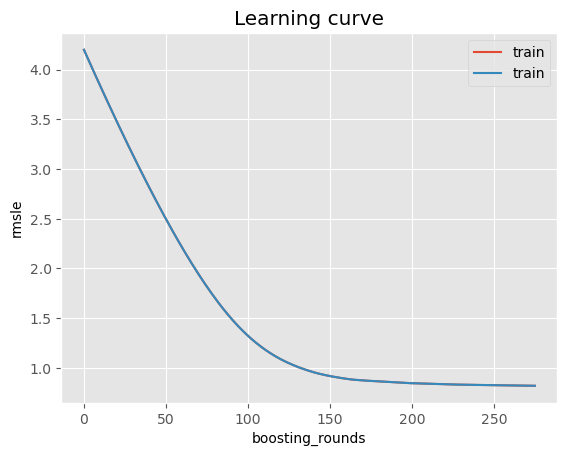

In [53]:
plt.plot(cv_results["train-rmsle-mean"], label = "train")
plt.plot(cv_results["train-rmsle-mean"], label = "train")
plt.xlabel("boosting_rounds")
plt.ylabel("rmsle")
plt.legend()
plt.title("Learning curve")

plt.show()

## Making predictions

In [54]:
df_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,month,year
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,1,2011
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1,2011
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2,1,2011
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3,1,2011
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4,1,2011


In [59]:
df_test["datetime"] = pd.to_datetime(df_test["datetime"], format ='%Y-%m-%d %H:%M:%S')
df_test.set_index(df_test["datetime"], inplace = True)
df_test.drop("datetime", axis = 1, inplace = True)

In [60]:
df_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [61]:
df_test["hour"] = df_test.index.hour
df_test["month"] = df_test.index.month
df_test["year"] = df_test.index.year

In [93]:
y_pred_final = rf_reg_opt.predict(df_test)

In [94]:
y_pred_final

array([  8.91666667,   5.45      ,   3.53333333, ..., 137.23333333,
       124.2       ,  73.8       ])

In [95]:
y_pred_final[y_pred_final< 0] = 0

In [96]:
sample_sub = pd.read_csv(r"C:\Users\rafae\kaggle\bike-sharing-demand\sampleSubmission.csv")

In [97]:
sample_sub

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0
...,...,...
6488,2012-12-31 19:00:00,0
6489,2012-12-31 20:00:00,0
6490,2012-12-31 21:00:00,0
6491,2012-12-31 22:00:00,0


In [98]:
sample_sub["count"] = y_pred_final

In [99]:
sample_sub.to_csv("submission.csv", index = False)